In [1]:
# Cell 1 — Imports & plotting defaults
import pandas as pd
import numpy as np
from pathlib import Path
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import Plotly for interactive charts; fall back if missing
try:
    import plotly.graph_objects as go
    import plotly.express as px
    PLOTLY = True
except Exception:
    PLOTLY = False

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14,5)
sns.set_context("notebook")


In [2]:
# Cell 2 — Load CRUDEOIL file & robust datetime parsing
DATA_PATH = Path("Data/CRUDEOIL_FUT.csv")
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Place CRUDEOIL_FUT.csv at this location.")

df = pd.read_csv(DATA_PATH, dtype=str)
df.columns = [c.strip() for c in df.columns]

# normalize spaces and parse datetime (dayfirst)
df['datetime_raw'] = df['datetime'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
df['datetime'] = pd.to_datetime(df['datetime_raw'], dayfirst=True, errors='coerce')

# numeric casts
for col in ['open','high','low','close','volume']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Rows loaded:", len(df))
print("Datetime parse failures (NaT):", df['datetime'].isna().sum())
df.head(6)


Rows loaded: 555564
Datetime parse failures (NaT): 332875


,datetime,tradingsymbol,expiry,open,high,low,close,volume,datetime_raw
0,2021-01-07 09:00:00,CRUDEOIL21JULFUT,2021-07-19,5485.0,5493.0,5485.0,5491.0,52.0,2021-07-01 09:00:00
1,2021-01-07 09:01:00,CRUDEOIL21JULFUT,2021-07-19,5491.0,5492.0,5490.0,5490.0,24.0,2021-07-01 09:01:00
2,2021-01-07 09:02:00,CRUDEOIL21JULFUT,2021-07-19,5490.0,5492.0,5489.0,5490.0,56.0,2021-07-01 09:02:00
3,2021-01-07 09:03:00,CRUDEOIL21JULFUT,2021-07-19,5490.0,5491.0,5490.0,5491.0,8.0,2021-07-01 09:03:00
4,2021-01-07 09:04:00,CRUDEOIL21JULFUT,2021-07-19,5491.0,5491.0,5490.0,5490.0,12.0,2021-07-01 09:04:00
5,2021-01-07 09:05:00,CRUDEOIL21JULFUT,2021-07-19,5491.0,5491.0,5488.0,5488.0,34.0,2021-07-01 09:05:00


In [3]:
# Cell 3 — EOD extraction using 23:59 cutoff for commodities
EOD_CUTOFF = "23:59"   # commodity EOD (adjust if your exchange uses different cutoff)
df = df.dropna(subset=['datetime']).copy()

# seconds of day, calendar date
df['sec_of_day'] = df['datetime'].dt.hour*3600 + df['datetime'].dt.minute*60 + df['datetime'].dt.second
df['cal_date'] = df['datetime'].dt.date

hh, mm = map(int, EOD_CUTOFF.split(':'))
cutoff_sec = hh*3600 + mm*60

df['market_date'] = pd.to_datetime(df['cal_date'])
after_mask = df['sec_of_day'] > cutoff_sec
df.loc[after_mask, 'market_date'] = df.loc[after_mask, 'market_date'] + pd.Timedelta(days=1)

df['eod_cutoff_ts'] = df['market_date'] + pd.to_timedelta(f"{EOD_CUTOFF}:00")
valid = df[df['datetime'] <= df['eod_cutoff_ts']].copy()
if valid.empty:
    raise ValueError("No valid ticks <= cutoff found. Check timestamps or cutoff.")

idx = valid.groupby('market_date')['datetime'].idxmax()
eod = valid.loc[idx, ['market_date','datetime','open','high','low','close','volume','tradingsymbol']].copy()
eod['date'] = eod['market_date'].dt.date
eod = eod.sort_values('date').reset_index(drop=True)
print("EOD rows extracted:", len(eod))
eod.head()


EOD rows extracted: 261


,market_date,datetime,open,high,low,close,volume,tradingsymbol,date
0,2021-01-07,2021-01-07 23:29:00,5589.0,5595.0,5586.0,5588.0,77.0,CRUDEOIL21JULFUT,2021-01-07
1,2021-01-09,2021-01-09 23:29:00,4993.0,4995.0,4990.0,4993.0,45.0,CRUDEOIL21SEPFUT,2021-01-09
2,2021-01-10,2021-01-10 23:29:00,5628.0,5631.0,5626.0,5630.0,180.0,CRUDEOIL21OCTFUT,2021-01-10
3,2021-01-11,2021-01-11 23:29:00,6292.0,6293.0,6289.0,6293.0,122.0,CRUDEOIL21NOVFUT,2021-01-11
4,2021-01-12,2021-01-12 23:54:00,5016.0,5017.0,5010.0,5011.0,103.0,CRUDEOIL21DECFUT,2021-01-12


In [4]:
# Cell 4 — Prepare daily series for visuals and indicators
series = eod[['date','open','high','low','close','volume']].copy()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').asfreq('D')   # calendar index for smooth plots
series['open']  = pd.to_numeric(series['open'], errors='coerce').ffill()
series['high']  = pd.to_numeric(series['high'], errors='coerce').ffill()
series['low']   = pd.to_numeric(series['low'], errors='coerce').ffill()
series['close'] = pd.to_numeric(series['close'], errors='coerce').ffill()
series['volume'] = pd.to_numeric(series['volume'], errors='coerce').fillna(0)

# rolling stats
series['ma20'] = series['close'].rolling(20).mean()
series['ma50'] = series['close'].rolling(50).mean()
series['std20'] = series['close'].rolling(20).std()
series['bb_up'] = series['ma20'] + 2*series['std20']
series['bb_dn'] = series['ma20'] - 2*series['std20']

# returns & vol
series['returns'] = series['close'].pct_change()
series['vol_14'] = series['returns'].rolling(14).std() * math.sqrt(252)

series.tail(6)


,open,high,low,close,volume,ma20,ma50,std20,bb_up,bb_dn,returns,vol_14
date,,,,,,,,,,,,
2025-01-27,6172.0,6172.0,6172.0,6172.0,0.0,6172.0,6069.24,0.000000,6172.000000,6172.000000,0.000000,0.000000
2025-01-28,6172.0,6172.0,6172.0,6172.0,0.0,6172.0,6076.56,0.000000,6172.000000,6172.000000,0.000000,0.000000
2025-01-29,6172.0,6172.0,6172.0,6172.0,0.0,6172.0,6083.88,0.000000,6172.000000,6172.000000,0.000000,0.000000
2025-01-30,6172.0,6172.0,6172.0,6172.0,0.0,6172.0,6091.20,0.000000,6172.000000,6172.000000,0.000000,0.000000
2025-01-31,6172.0,6172.0,6172.0,6172.0,0.0,6172.0,6095.24,0.000000,6172.000000,6172.000000,0.000000,0.000000
2025-02-01,6301.0,6301.0,6296.0,6296.0,45.0,6178.2,6101.76,27.727243,6233.654486,6122.745514,0.020091,0.085238


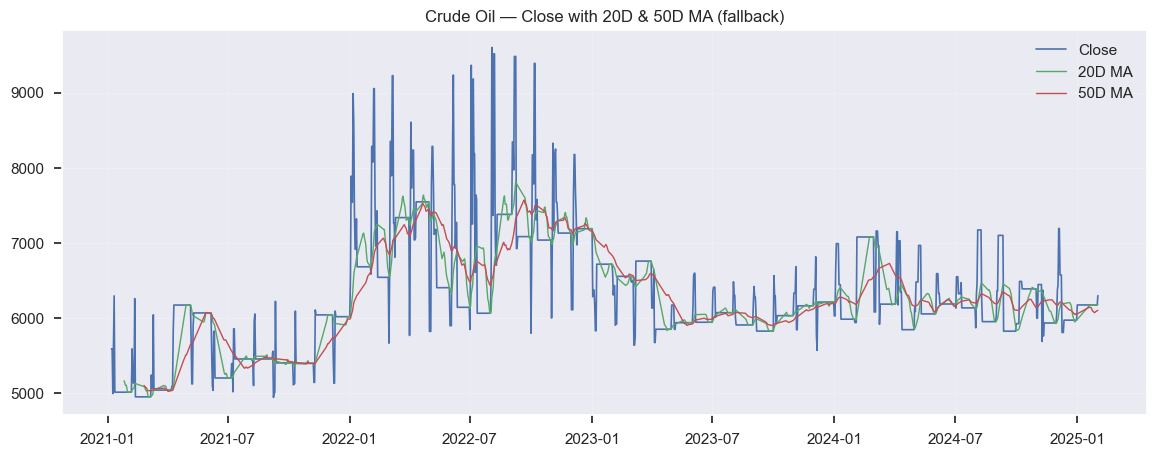

In [5]:
# Cell 5 — Candlestick / OHLC visualization (interactive if Plotly available)
if PLOTLY:
    fig = go.Figure(data=[go.Candlestick(
        x=series.index,
        open=series['open'],
        high=series['high'],
        low=series['low'],
        close=series['close'],
        name='Crude OHLC'
    )])
    fig.update_layout(title='Crude Oil — Daily Candlestick', xaxis_title='Date', yaxis_title='Price', height=600)
    # overlay MA lines
    fig.add_trace(go.Scatter(x=series.index, y=series['ma20'], mode='lines', name='20D MA', line=dict(width=1)))
    fig.add_trace(go.Scatter(x=series.index, y=series['ma50'], mode='lines', name='50D MA', line=dict(width=1)))
    fig.show()
else:
    plt.figure(figsize=(14,5))
    plt.plot(series.index, series['close'], label='Close', linewidth=1.2)
    plt.plot(series.index, series['ma20'], label='20D MA', linewidth=1)
    plt.plot(series.index, series['ma50'], label='50D MA', linewidth=1)
    plt.title('Crude Oil — Close with 20D & 50D MA (fallback)')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()


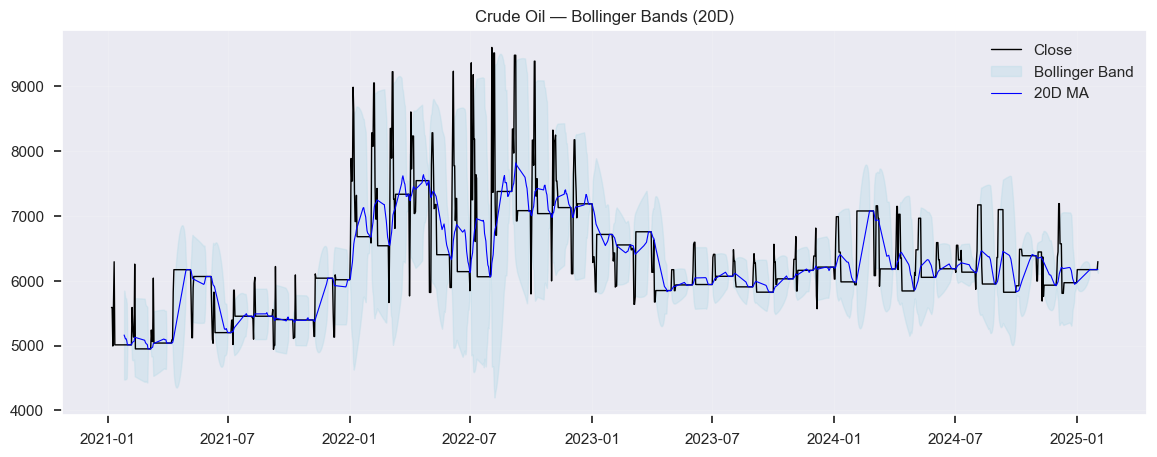

In [6]:
# Cell 6 — Bollinger Bands area (Matplotlib)
plt.figure(figsize=(14,5))
plt.plot(series.index, series['close'], label='Close', color='black', linewidth=1)
plt.fill_between(series.index, series['bb_up'], series['bb_dn'], color='lightblue', alpha=0.3, label='Bollinger Band')
plt.plot(series.index, series['ma20'], label='20D MA', color='blue', linewidth=0.8)
plt.title('Crude Oil — Bollinger Bands (20D)')
plt.legend()
plt.grid(alpha=0.15)
plt.show()


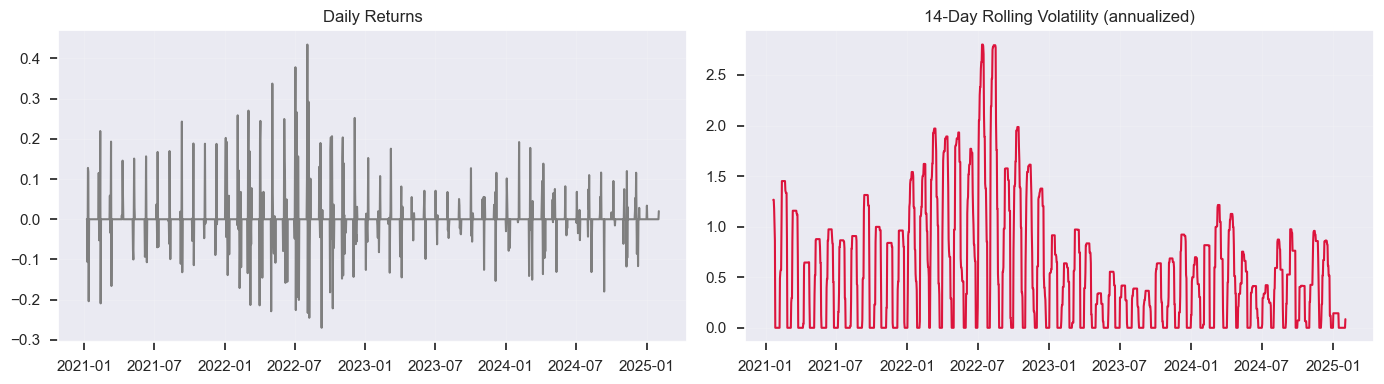

In [7]:
# Cell 7 — Volatility and returns (small multiple)
fig, axes = plt.subplots(1,2, figsize=(14,4))
axes[0].plot(series.index, series['returns'].fillna(0), color='tab:gray')
axes[0].set_title('Daily Returns')
axes[0].grid(alpha=0.15)

axes[1].plot(series.index, series['vol_14'], color='crimson')
axes[1].set_title('14-Day Rolling Volatility (annualized)')
axes[1].grid(alpha=0.15)
plt.tight_layout()
plt.show()


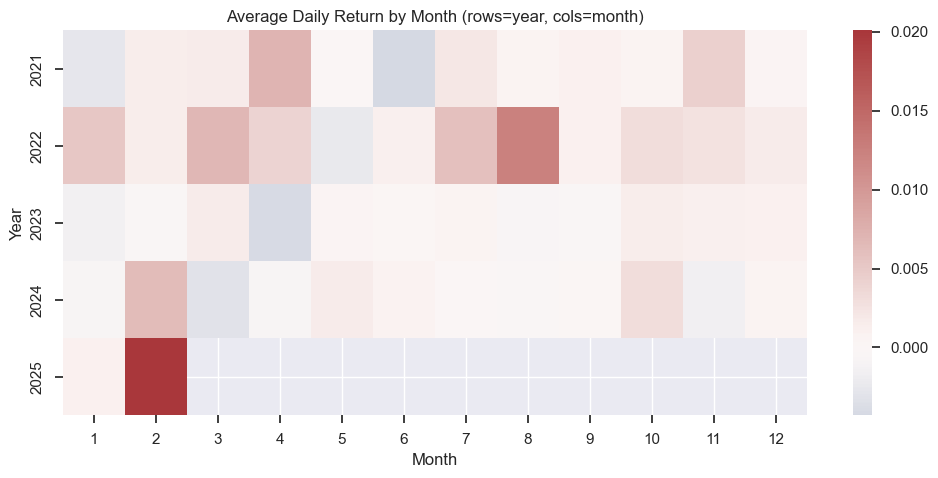

In [8]:
# Cell 8 — Monthly seasonality heatmap (mean monthly returns)
df_month = series['returns'].dropna().to_frame()
df_month['year'] = df_month.index.year
df_month['month'] = df_month.index.month
pivot = df_month.groupby(['year','month'])['returns'].mean().unstack(level=0).T  # years as rows
plt.figure(figsize=(12,5))
sns.heatmap(pivot, center=0, cmap='vlag', annot=False)
plt.title('Average Daily Return by Month (rows=year, cols=month)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


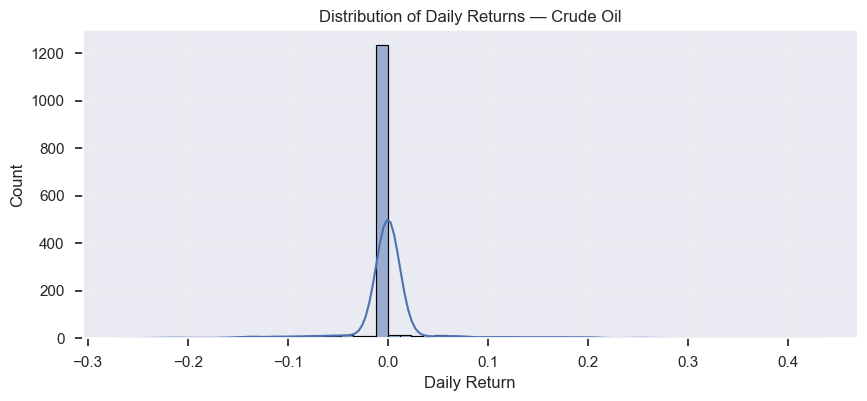

Top 5 up days (return, date):
date
2022-08-03    0.434120
2022-07-03    0.377722
2022-05-04    0.337113
2022-08-06    0.291921
2022-03-03    0.269962
Name: returns, dtype: float64

Top 5 down days (return, date):
date
2022-09-09   -0.269726
2022-08-08   -0.244877
2022-08-04   -0.232812
2022-05-01   -0.228628
2022-07-04   -0.225676
Name: returns, dtype: float64


In [9]:
# Cell 9 — Return distribution + top moves
ret = series['returns'].dropna()
plt.figure(figsize=(10,4))
sns.histplot(ret, bins=60, kde=True)
plt.title('Distribution of Daily Returns — Crude Oil')
plt.xlabel('Daily Return')
plt.grid(alpha=0.2)
plt.show()

# show top 5 up and down days
top_up = series['returns'].nlargest(5)
top_down = series['returns'].nsmallest(5)
print("Top 5 up days (return, date):")
print(top_up)
print("\nTop 5 down days (return, date):")
print(top_down)


In [11]:
# Cell 11 — Top-level metrics for display
latest_price = series['close'].dropna().iloc[-1]
period_pct = (series['close'].dropna().iloc[-1] / series['close'].dropna().iloc[0] - 1.0) * 100
recent_vol = series['vol_14'].dropna().iloc[-1] if series['vol_14'].dropna().size else np.nan

print("Crude Oil Snapshot")
print("Latest price:", round(latest_price,2))
print("Overall change (period):", f"{period_pct:.2f}%")
print("Recent annualized vol (14d):", round(recent_vol,3))


Crude Oil Snapshot
Latest price: 6296.0
Overall change (period): 12.67%
Recent annualized vol (14d): 0.085


In [12]:
# Cell 12 — Optional small baseline model (5-lag RF) — quick demo only
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    df_tab = series[['close']].copy().reset_index().rename(columns={'index':'date'})
    for lag in range(1,6):
        df_tab[f'lag_{lag}'] = df_tab['close'].shift(lag)
    df_tab = df_tab.dropna().reset_index(drop=True)
    X = df_tab[[f'lag_{l}' for l in range(1,6)]].values
    y = df_tab['close'].shift(-1).ffill().values
    if len(X) < 50:
        print("Not enough rows for baseline demo; skipping.")
    else:
        split = int(len(X)*0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]
        model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        rmse = mean_squared_error(y_test, preds) ** 0.5
        print("Baseline (5-lag) MAE:", round(mae,2))
        print("Baseline (5-lag) RMSE:", round(rmse,2))
except Exception as ex:
    print("Baseline skipped (sklearn missing or error):", ex)


Baseline (5-lag) MAE: 207.45
Baseline (5-lag) RMSE: 372.67


In [13]:
# Cell 13 — Final note for embedding and exporting
print("CRUDEOIL showcase notebook ready.")
print("Export to HTML for embedding in React using:")
print("jupyter nbconvert --to html your_notebook_filename.ipynb --output public/notebooks/crude_showcase.html")


CRUDEOIL showcase notebook ready.
Export to HTML for embedding in React using:
jupyter nbconvert --to html your_notebook_filename.ipynb --output public/notebooks/crude_showcase.html
